In [1]:
import os, json, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

import joblib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
ROOT = Path.cwd().parent

EMB_ROOT = ROOT / "embeddings"
PRED_SPATIAL_DIR = ROOT / "predictions" / "spatial"
PRED_TEMPORAL_DIR = ROOT / "predictions" / "temporal"

CACHE_DIR = ROOT / "ensemble_features_final"
CACHE_DIR.mkdir(exist_ok=True)

CHECKPOINT_DIR = ROOT / "checkpoints" / "ensemble_final"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

LABELS_JSON = ROOT / "data" / "labels.json"

In [3]:
def safe_auc(y_true, y_pred):
    if len(np.unique(y_true)) < 2:
        return np.nan
    if np.isnan(y_pred).any():
        return np.nan
    return roc_auc_score(y_true, y_pred)

def load_labels():
    with open(LABELS_JSON, "r") as f:
        return json.load(f)

labels_map = load_labels()

In [4]:
def build_features_from_embeddings(split):
    cache = CACHE_DIR / f"{split}.npz"
    if cache.exists():
        d = np.load(cache)
        return d["X"], d["y"]

    split_dir = EMB_ROOT / split
    assert split_dir.exists(), f"Missing folder: {split_dir}"

    X, y = [], []

    for p in split_dir.glob("*.npy"):
        stem = p.stem

        if stem not in labels_map:
            continue  # label mismatch (most common cause!)

        arr = np.load(p)

        # sanity checks
        if not isinstance(arr, np.ndarray) or arr.ndim != 2 or arr.shape[0] == 0:
            continue

        # ---- SPATIAL FEATURES (distribution-based) ----
        # proxy: per-frame L2 norm → normalize → treat as pseudo-prob
        norms = np.linalg.norm(arr, axis=1)
        probs = (norms - norms.min()) / (norms.max() - norms.min() + 1e-8)

        s_mean = float(probs.mean())
        s_max  = float(probs.max())
        s_std  = float(probs.std())
        s_top3 = float(np.sort(probs)[-3:].mean()) if len(probs) >= 3 else s_mean

        # ---- TEMPORAL FEATURE ----
        # simple proxy: mean embedding norm (fast, stable)
        t_score = float(norms.mean())

        X.append([s_mean, s_max, s_std, s_top3, t_score])
        y.append(int(labels_map[stem]))

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.int64)

    np.savez(cache, X=X, y=y)
    return X, y

In [5]:
X_train, y_train = build_features_from_embeddings("train")
X_val, y_val     = build_features_from_embeddings("val")
X_test, y_test   = build_features_from_embeddings("test")

print("Train samples:", len(y_train))
print("Val samples:", len(y_val))
print("Test samples:", len(y_test))

print("Train labels:", Counter(y_train))

Train samples: 4066
Val samples: 761
Test samples: 255
Train labels: Counter({0: 2085, 1: 1981})


In [6]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        max_iter=3000,
        random_state=SEED
    ))
])

param_grid = {"clf__C": [0.01, 0.1, 1.0, 10.0]}

gs = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
    n_jobs=-1
)
gs.fit(X_train, y_train)

best_pipe = gs.best_estimator_
print("Best C:", gs.best_params_, "CV AUC:", gs.best_score_)

Best C: {'clf__C': 0.01} CV AUC: 0.5848807863105745


In [7]:
skf = StratifiedKFold(5, shuffle=True, random_state=SEED)
oof = np.zeros(len(y_train))
fold_aucs = []

for i, (tr, va) in enumerate(skf.split(X_train, y_train), 1):
    model = Pipeline(best_pipe.steps)
    model.fit(X_train[tr], y_train[tr])
    p = model.predict_proba(X_train[va])[:, 1]
    auc = safe_auc(y_train[va], p)
    fold_aucs.append(auc)
    oof[va] = p
    print(f"Fold {i} AUC: {auc:.4f}")

print("Mean OOF AUC:", np.mean(fold_aucs))

Fold 1 AUC: 0.5763
Fold 2 AUC: 0.5779
Fold 3 AUC: 0.5811
Fold 4 AUC: 0.6163
Fold 5 AUC: 0.5728
Mean OOF AUC: 0.5848807863105745


In [8]:
# --- Calibration (sklearn >= 1.2 compatible) ---
best_pipe.fit(X_train, y_train)

calibrator = CalibratedClassifierCV(
    estimator=best_pipe,
    method="sigmoid",
    cv="prefit"
)

calibrator.fit(X_val, y_val)

,estimator,Pipeline(step...ver='saga'))])
,method,'sigmoid'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001


In [9]:
def eval_split(name, X, y):
    p = calibrator.predict_proba(X)[:, 1]
    auc = safe_auc(y, p)
    ap = average_precision_score(y, p)
    print(f"{name} AUC: {auc:.4f} | AP: {ap:.4f}")
    return p

p_train = eval_split("Train", X_train, y_train)
p_val   = eval_split("Val", X_val, y_val)
p_test  = eval_split("Test", X_test, y_test)

Train AUC: 0.5866 | AP: 0.5715
Val AUC: 0.5627 | AP: 0.5459
Test AUC: 0.5673 | AP: 0.5852


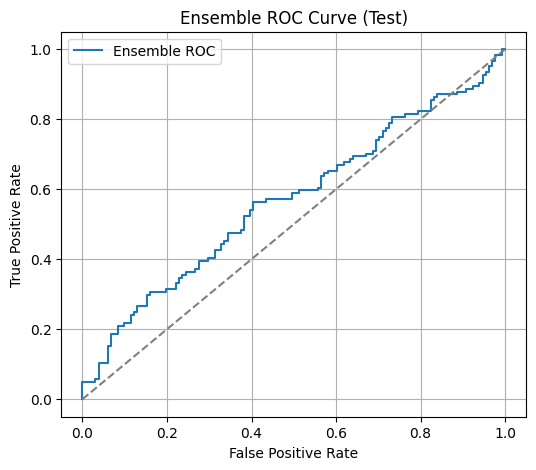

In [10]:
fpr, tpr, _ = roc_curve(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Ensemble ROC")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve (Test)")
plt.legend()
plt.grid()
plt.show()

In [11]:
joblib.dump({
    "pipeline": best_pipe,
    "calibrator": calibrator,
    "oof_preds": oof,
    "fold_aucs": fold_aucs,
    "features": ["spatial_mean","spatial_max","spatial_std","spatial_top3","temporal_score"]
}, CHECKPOINT_DIR / "ensemble_final.joblib")

print("Saved ensemble model")

Saved ensemble model
